# CC3092 — Deep Learning – Hoja de Trabajo 2

Integrantes: 
Diego Valenzuela - 22309
Gerson Ramirez - 22281

**Compatibilidad:** El archivo de requirements.txt fue establecido para la instalación de dependencias específicas para trabajar con el proyecto utilizando Apple Silicon Chips.

# Ejercicio 01 - Experimentación Práctica

In [1]:
import torch
print("torch version:", torch.__version__)
print("MPS disponible:", torch.backends.mps.is_available())
print("MPS creado:", torch.backends.mps.is_built())
if torch.backends.mps.is_available():
    print("GPU: Apple Silicon Metal Performance Shaders")
    x = torch.rand((2, 2), device="mps")
    print("Tensor en dispositivo:", x.device)
elif torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    x = torch.rand((2, 2), device="cuda")
    print("Tensor en dispositivo:", x.device)
else:
    print("Usando CPU")
    x = torch.rand((2, 2), device="cpu")
    print("Tensor en dispositivo:", x.device)

torch version: 2.8.0
MPS disponible: True
MPS creado: True
GPU: Apple Silicon Metal Performance Shaders
Tensor en dispositivo: mps:0


In [2]:
import time, math, random
from dataclasses import dataclass
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(False)  
set_seed(42)

# Apple Silicon optimized device selection
def get_device():
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")
device

Using device: mps


device(type='mps')

## Task 1 — Carga de Iris + split (train/val) + escalado

Se usa Iris para clasificación multiclase (3 clases). Se separa 75/25 (train/val) con estratificación para mantener proporciones de clases. Se estandarizan atributos (media 0, var 1), lo que acelera y estabiliza el entrenamiento del MLP.

In [3]:
iris = load_iris()
X = iris.data.astype(np.float32)
y = iris.target.astype(np.int64)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).astype(np.float32)
X_val   = scaler.transform(X_val).astype(np.float32)

# Move tensors to the appropriate device (MPS for Apple Silicon)
X_train_t = torch.from_numpy(X_train).to(device)
y_train_t = torch.from_numpy(y_train).to(device)
X_val_t   = torch.from_numpy(X_val).to(device)
y_val_t   = torch.from_numpy(y_val).to(device)

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)

len(train_ds), len(val_ds)

(112, 38)

## Task 2 — MLP simple y parametrizable

Arquitectura feedforward con capas ocultas configurables, activación seleccionable y Dropout (para Task 4). La capa final entrega logits (sin softmax); la función de pérdida se encarga de lo demás.

In [4]:
class MLP(nn.Module):
    def __init__(self, in_dim: int = 4, hidden: List[int] = [32, 16],
                 out_dim: int = 3, activation: str = "relu", dropout_p: float = 0.0):
        super().__init__()
        acts = {
            "relu": nn.ReLU(),
            "tanh": nn.Tanh(),
            "gelu": nn.GELU(),
            "leakyrelu": nn.LeakyReLU(0.1),
        }
        self.act = acts.get(activation.lower(), nn.ReLU())
        layers = []
        prev = in_dim
        for h in hidden:
            layers += [nn.Linear(prev, h), self.act]
            if dropout_p and dropout_p > 0.0:
                layers += [nn.Dropout(dropout_p)]
            prev = h
        layers += [nn.Linear(prev, out_dim)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


## Task 3 — Funciones de pérdida (CE, NLL, MSE) parametrizadas

Usaremos CrossEntropyLoss, NLLLoss (con log_softmax) y MSE (con one-hot + softmax). Esto cumple el requisito de ≥3 pérdidas y permite comparar convergencia y rendimiento

In [5]:
@dataclass
class LossAdapter:
    name: str
    criterion: nn.Module
    def __call__(self, logits: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        if self.name == "cross_entropy":
            return self.criterion(logits, y)
        elif self.name == "nll":
            return self.criterion(F.log_softmax(logits, dim=1), y)
        elif self.name == "mse":
            probs = F.softmax(logits, dim=1)
            one_hot = F.one_hot(y, num_classes=logits.shape[1]).float()
            return self.criterion(probs, one_hot)
        else:
            raise ValueError(f"Pérdida desconocida: {self.name}")

def make_loss(name: str) -> LossAdapter:
    name = name.lower()
    if name in ("crossentropy", "ce", "cross_entropy"):
        return LossAdapter("cross_entropy", nn.CrossEntropyLoss())
    if name in ("nll", "nllloss"):
        return LossAdapter("nll", nn.NLLLoss())
    if name in ("mse", "mseloss"):
        return LossAdapter("mse", nn.MSELoss())
    raise ValueError(f"Pérdida no soportada: {name}")


## Task 4 — Regularización (L1, L2, Dropout)

* L2: se usa como weight_decay del optimizador.
* L1: se suma manualmente a la pérdida: λ₁ * Σ|w|.
* Dropout: parametrizado en el modelo (ya incluido).

In [6]:
def l1_penalty(model: nn.Module) -> torch.Tensor:
    total = torch.tensor(0., device=device)
    for p in model.parameters():
        if p.requires_grad:
            total = total + p.abs().sum()
    return total

## Task 5 — Algoritmos de optimización

* Batch GD: actualiza con todo el conjunto de entrenamiento (batch único).
* Mini-Batch GD: actualiza por lotes pequeños (p. ej. 16).
* SGD: actualiza por cada muestra (batch_size=1).

> Usaremos el mismo optimizador (torch.optim.SGD) pero cambiaremos el tamaño del batch para reflejar cada técnica.

In [7]:
def make_loader(dataset, mode: str, batch_size: int = 16, shuffle: bool = True):
    mode = mode.lower()
    if mode == "batch_gd":
        bs = len(dataset)
    elif mode == "sgd":
        bs = 1
    elif mode == "mini-batch" or mode == "mini_batch":
        bs = batch_size
    else:
        raise ValueError("mode debe ser 'batch_gd', 'mini-batch' o 'sgd'")
    return DataLoader(dataset, batch_size=bs, shuffle=shuffle)


## Task 6 — Experimentación y Análisis

In [8]:
@dataclass
class ExperimentConfig:
    loss_fn: str = "cross_entropy"
    l1_reg: float = 0.0
    l2_reg: float = 0.0
    dropout: float = 0.0
    opt_mode: str = "mini_batch"
    lr: float = 0.001
    epochs: int = 200
    hidden: List[int] = None
    
    def __post_init__(self):
        if self.hidden is None:
            self.hidden = [32, 16]

def train_model(config: ExperimentConfig, train_ds, val_ds, device=device, verbose=False):
    """Training function optimized for Metal/MPS"""
    model = MLP(
        in_dim=4, 
        hidden=config.hidden, 
        out_dim=3, 
        dropout_p=config.dropout
    ).to(device)
    
    loss_adapter = make_loss(config.loss_fn)
    optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, weight_decay=config.l2_reg)
    
    train_loader = make_loader(train_ds, config.opt_mode, batch_size=16)
    val_loader = make_loader(val_ds, "batch_gd", shuffle=False)
    
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': [],
        'train_f1': [], 'val_f1': []
    }
    
    start_time = time.time()
    
    for epoch in range(config.epochs):
        # Training phase
        model.train()
        train_loss, train_correct, train_total = 0.0, 0, 0
        train_preds, train_targets = [], []
        
        for X_batch, y_batch in train_loader:
            # Ensure tensors are on the correct device (Metal/MPS)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = loss_adapter(logits, y_batch)
            
            # Add L1 regularization if specified
            if config.l1_reg > 0:
                loss = loss + config.l1_reg * l1_penalty(model)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * len(X_batch)
            train_correct += (logits.argmax(1) == y_batch).sum().item()
            train_total += len(X_batch)
            
            # Collect predictions for F1 score (move to CPU for sklearn)
            train_preds.extend(logits.argmax(1).cpu().numpy())
            train_targets.extend(y_batch.cpu().numpy())
        
        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        val_preds, val_targets = [], []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                logits = model(X_batch)
                loss = loss_adapter(logits, y_batch)
                
                if config.l1_reg > 0:
                    loss = loss + config.l1_reg * l1_penalty(model)
                
                val_loss += loss.item() * len(X_batch)
                val_correct += (logits.argmax(1) == y_batch).sum().item()
                val_total += len(X_batch)
                
                val_preds.extend(logits.argmax(1).cpu().numpy())
                val_targets.extend(y_batch.cpu().numpy())
        
        # Calculate metrics
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        train_f1 = f1_score(train_targets, train_preds, average='weighted')
        val_f1 = f1_score(val_targets, val_preds, average='weighted')
        
        history['train_loss'].append(train_loss / train_total)
        history['val_loss'].append(val_loss / val_total)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        
        if verbose and (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch+1:3d} | "
                  f"Train Loss: {train_loss/train_total:.4f} | "
                  f"Val Loss: {val_loss/val_total:.4f} | "
                  f"Train Acc: {train_acc:.4f} | "
                  f"Val Acc: {val_acc:.4f}")
    
    total_time = time.time() - start_time
    
    return {
        'model': model,
        'history': history,
        'final_train_acc': train_acc,
        'final_val_acc': val_acc,
        'final_train_f1': train_f1,
        'final_val_f1': val_f1,
        'training_time': total_time,
        'config': config
    }

In [9]:
# Define 9+ experimental configurations
experiments = [
    # Baseline: different loss functions with no regularization
    ExperimentConfig(loss_fn="cross_entropy", opt_mode="mini_batch"),
    ExperimentConfig(loss_fn="nll", opt_mode="mini_batch"),
    ExperimentConfig(loss_fn="mse", opt_mode="mini_batch"),
    
    # Different regularization techniques with CrossEntropy
    ExperimentConfig(loss_fn="cross_entropy", l1_reg=0.001, opt_mode="mini_batch"),
    ExperimentConfig(loss_fn="cross_entropy", l2_reg=0.001, opt_mode="mini_batch"),
    ExperimentConfig(loss_fn="cross_entropy", dropout=0.3, opt_mode="mini_batch"),
    
    # Different optimization methods with CrossEntropy
    ExperimentConfig(loss_fn="cross_entropy", opt_mode="sgd"),
    ExperimentConfig(loss_fn="cross_entropy", opt_mode="batch_gd"),
    ExperimentConfig(loss_fn="cross_entropy", opt_mode="mini_batch"),
    
    # Extra combinations for bonus points
    ExperimentConfig(loss_fn="nll", l1_reg=0.001, dropout=0.2, opt_mode="mini_batch"),
    ExperimentConfig(loss_fn="mse", l2_reg=0.01, dropout=0.1, opt_mode="batch_gd"),
]

print(f"Running {len(experiments)} experiments on {device}")
print("Experiment configurations:")
for i, config in enumerate(experiments):
    print(f"{i+1:2d}. Loss: {config.loss_fn:<12} | "
          f"L1: {config.l1_reg:<6} | L2: {config.l2_reg:<6} | "
          f"Dropout: {config.dropout:<4} | Opt: {config.opt_mode}")

Running 11 experiments on mps
Experiment configurations:
 1. Loss: cross_entropy | L1: 0.0    | L2: 0.0    | Dropout: 0.0  | Opt: mini_batch
 2. Loss: nll          | L1: 0.0    | L2: 0.0    | Dropout: 0.0  | Opt: mini_batch
 3. Loss: mse          | L1: 0.0    | L2: 0.0    | Dropout: 0.0  | Opt: mini_batch
 4. Loss: cross_entropy | L1: 0.001  | L2: 0.0    | Dropout: 0.0  | Opt: mini_batch
 5. Loss: cross_entropy | L1: 0.0    | L2: 0.001  | Dropout: 0.0  | Opt: mini_batch
 6. Loss: cross_entropy | L1: 0.0    | L2: 0.0    | Dropout: 0.3  | Opt: mini_batch
 7. Loss: cross_entropy | L1: 0.0    | L2: 0.0    | Dropout: 0.0  | Opt: sgd
 8. Loss: cross_entropy | L1: 0.0    | L2: 0.0    | Dropout: 0.0  | Opt: batch_gd
 9. Loss: cross_entropy | L1: 0.0    | L2: 0.0    | Dropout: 0.0  | Opt: mini_batch
10. Loss: nll          | L1: 0.001  | L2: 0.0    | Dropout: 0.2  | Opt: mini_batch
11. Loss: mse          | L1: 0.0    | L2: 0.01   | Dropout: 0.1  | Opt: batch_gd


In [10]:
# Run all experiments (optimized for Metal/MPS)
results = []
print("Starting experimental runs...")
print("=" * 80)

for i, config in enumerate(experiments):
    print(f"\nExperiment {i+1}/{len(experiments)}: "
          f"{config.loss_fn} + {config.opt_mode} + "
          f"L1={config.l1_reg} + L2={config.l2_reg} + dropout={config.dropout}")
    
    # Ensure fresh random state for each experiment
    set_seed(42 + i)
    
    # Run training
    result = train_model(config, train_ds, val_ds, device=device, verbose=False)
    results.append(result)
    
    print(f"✓ Completed in {result['training_time']:.2f}s | "
          f"Final Val Acc: {result['final_val_acc']:.4f} | "
          f"Final Val F1: {result['final_val_f1']:.4f}")

print("\n" + "=" * 80)
print("All experiments completed!")

# Create summary table
summary_data = []
for i, result in enumerate(results):
    config = result['config']
    summary_data.append({
        'Experiment': i + 1,
        'Loss Function': config.loss_fn,
        'L1 Reg': config.l1_reg,
        'L2 Reg': config.l2_reg,
        'Dropout': config.dropout,
        'Optimizer': config.opt_mode,
        'Train Acc': f"{result['final_train_acc']:.4f}",
        'Val Acc': f"{result['final_val_acc']:.4f}",
        'Train F1': f"{result['final_train_f1']:.4f}",
        'Val F1': f"{result['final_val_f1']:.4f}",
        'Time (s)': f"{result['training_time']:.2f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\nExperimental Results Summary:")
print(summary_df.to_string(index=False))

Starting experimental runs...

Experiment 1/11: cross_entropy + mini_batch + L1=0.0 + L2=0.0 + dropout=0.0
✓ Completed in 5.01s | Final Val Acc: 0.6579 | Final Val F1: 0.5610

Experiment 2/11: nll + mini_batch + L1=0.0 + L2=0.0 + dropout=0.0
✓ Completed in 3.13s | Final Val Acc: 0.6316 | Final Val F1: 0.5011

Experiment 3/11: mse + mini_batch + L1=0.0 + L2=0.0 + dropout=0.0
✓ Completed in 3.71s | Final Val Acc: 0.5000 | Final Val F1: 0.4082

Experiment 4/11: cross_entropy + mini_batch + L1=0.001 + L2=0.0 + dropout=0.0
✓ Completed in 4.64s | Final Val Acc: 0.6316 | Final Val F1: 0.5883

Experiment 5/11: cross_entropy + mini_batch + L1=0.0 + L2=0.001 + dropout=0.0
✓ Completed in 3.23s | Final Val Acc: 0.6842 | Final Val F1: 0.5987

Experiment 6/11: cross_entropy + mini_batch + L1=0.0 + L2=0.0 + dropout=0.3
✓ Completed in 3.69s | Final Val Acc: 0.8158 | Final Val F1: 0.8126

Experiment 7/11: cross_entropy + sgd + L1=0.0 + L2=0.0 + dropout=0.0
✓ Completed in 38.19s | Final Val Acc: 0.9211 

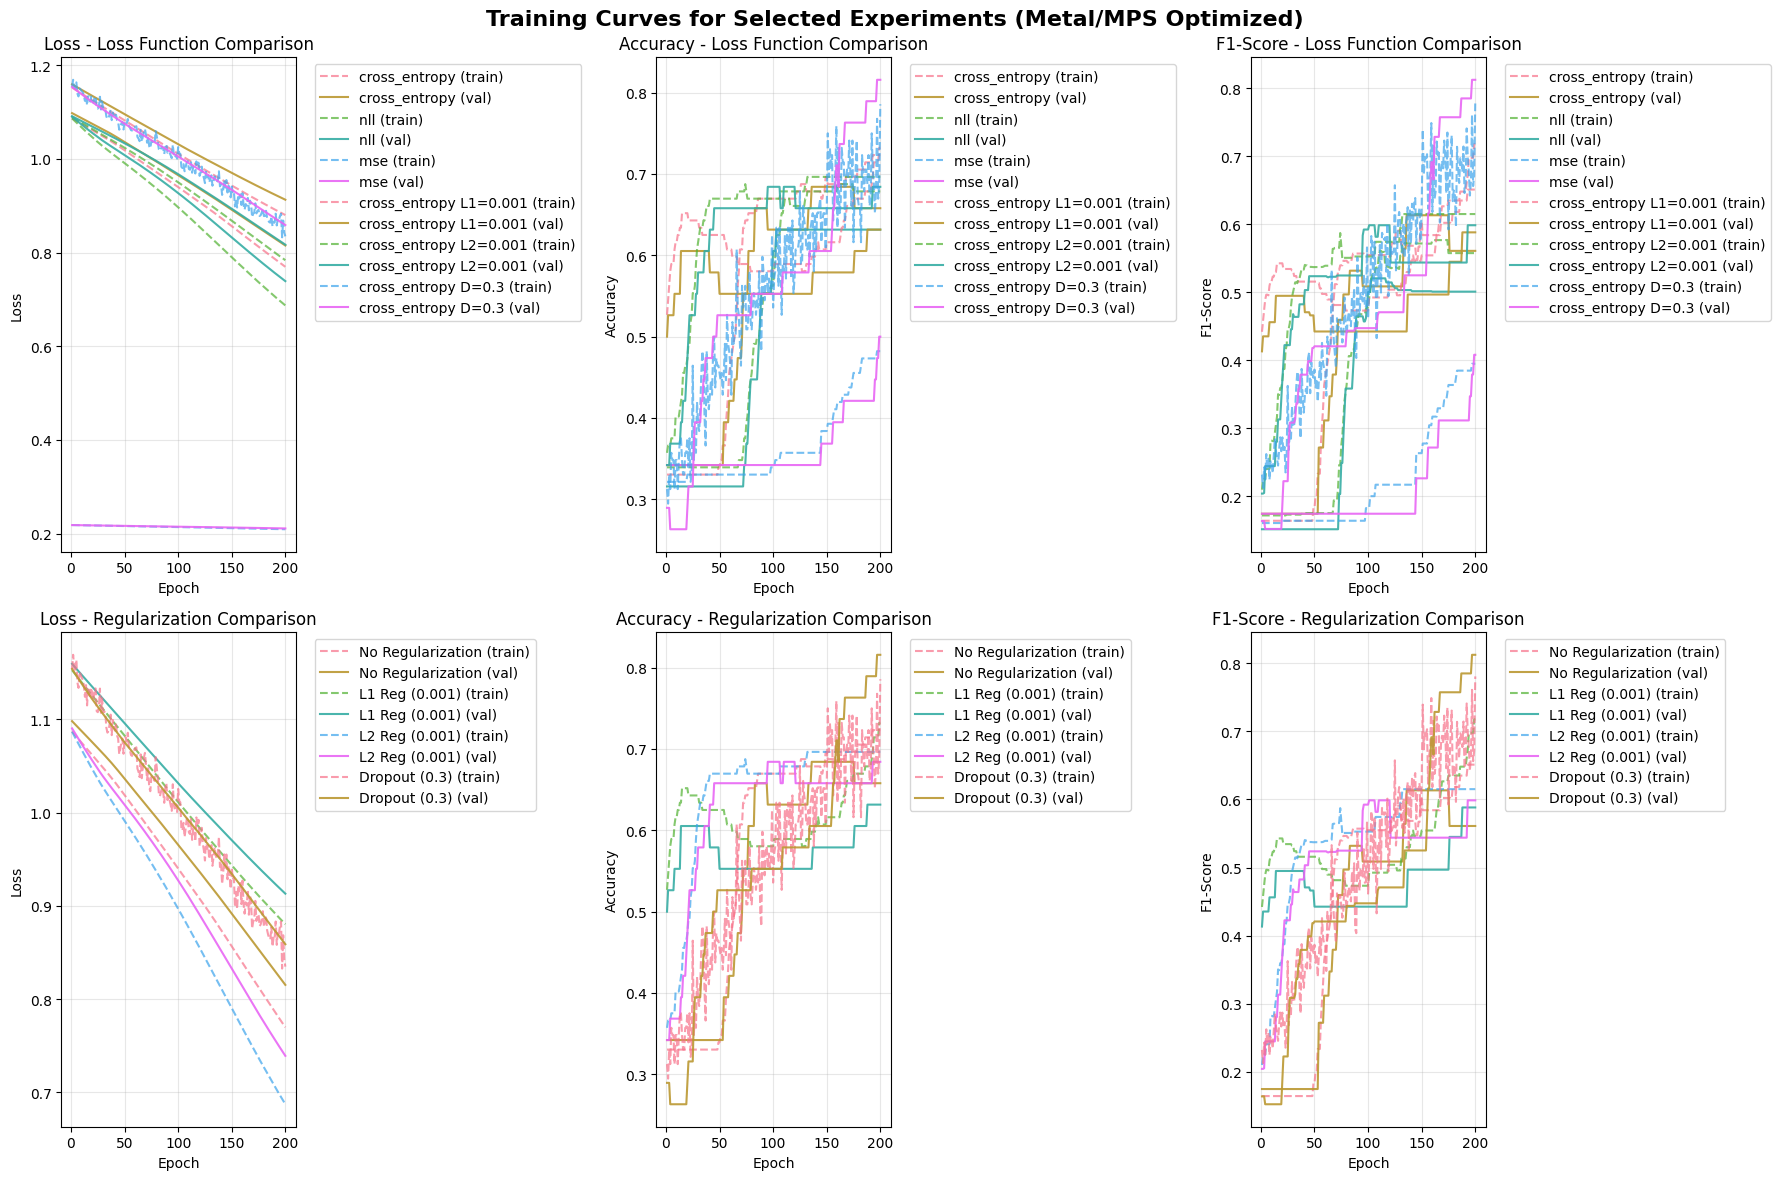

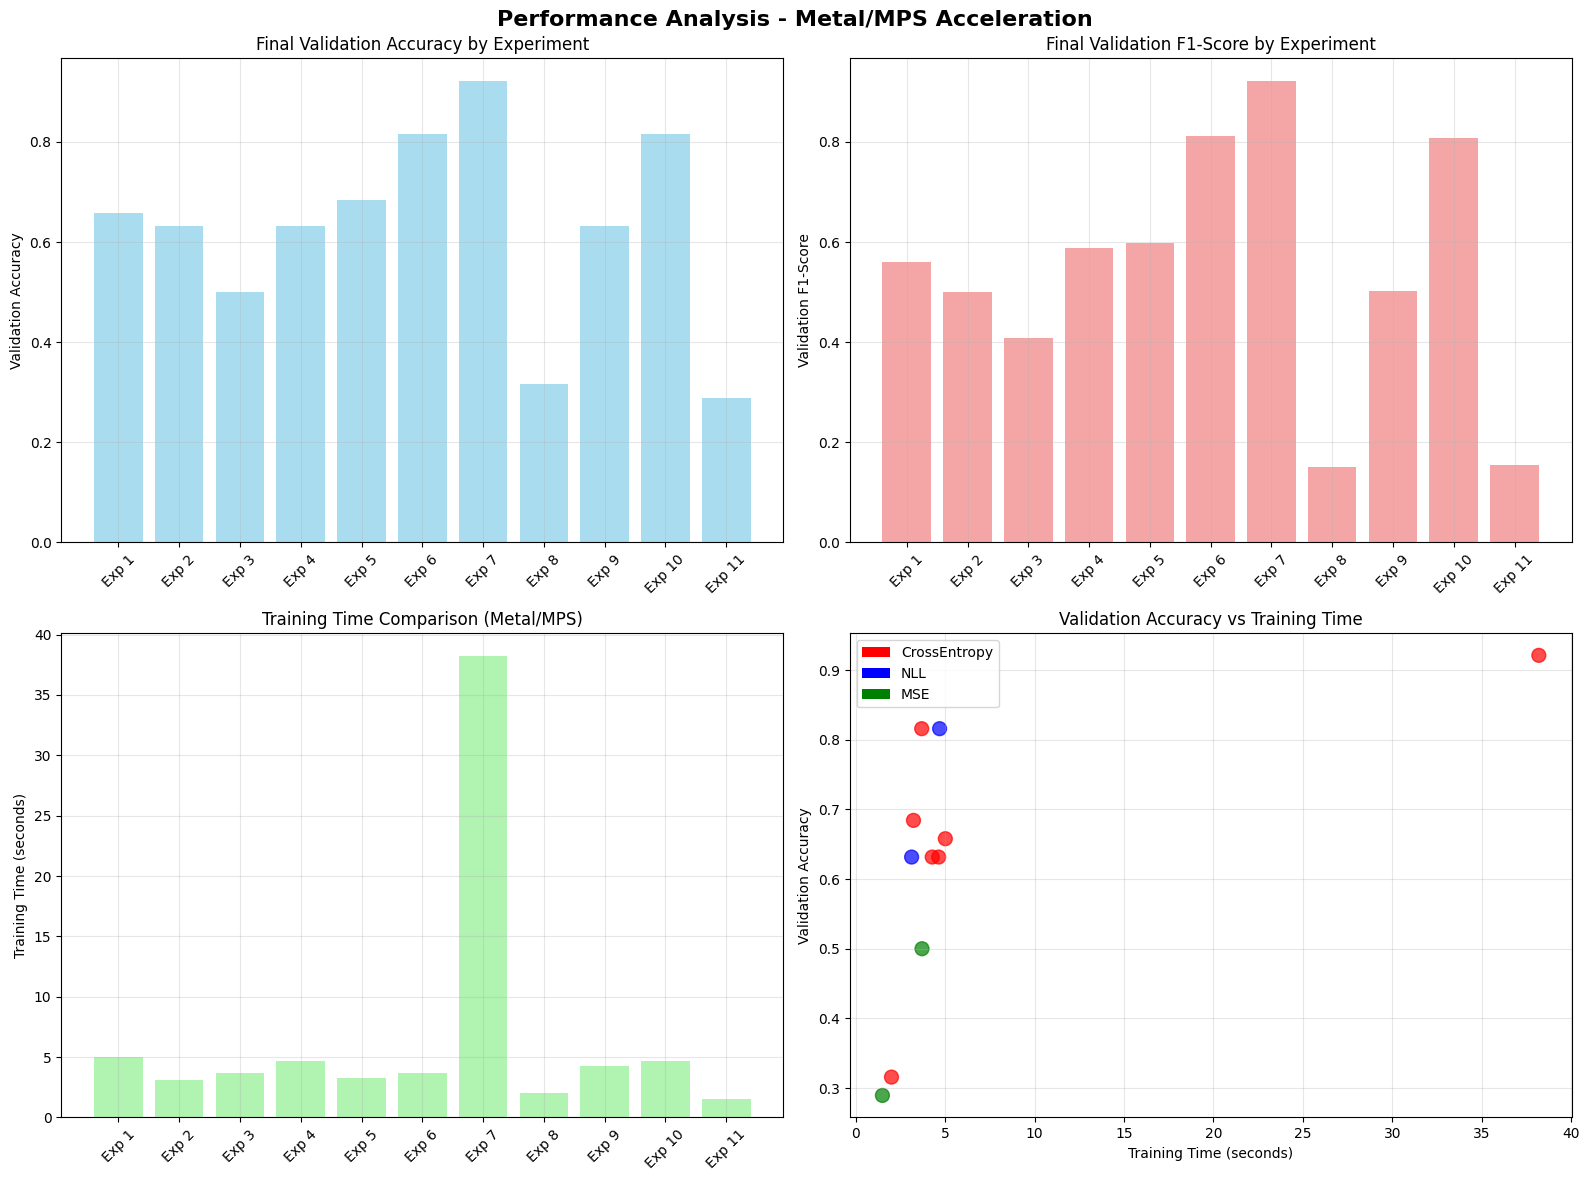

In [12]:
import seaborn as sns

plt.style.use('default')
sns.set_palette("husl")

# 1. Training curves for selected experiments
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Training Curves for Selected Experiments (Metal/MPS Optimized)', fontsize=16, fontweight='bold')

# Select interesting experiments to plot
selected_experiments = [0, 1, 2, 3, 4, 5]  # First 6 experiments
metrics = ['loss', 'acc', 'f1']
metric_names = ['Loss', 'Accuracy', 'F1-Score']

for i, metric in enumerate(metrics):
    ax = axes[0, i]
    for exp_idx in selected_experiments:
        result = results[exp_idx]
        config = result['config']
        epochs = range(1, len(result['history'][f'train_{metric}']) + 1)
        
        label = f"{config.loss_fn}"
        if config.l1_reg > 0:
            label += f" L1={config.l1_reg}"
        if config.l2_reg > 0:
            label += f" L2={config.l2_reg}"
        if config.dropout > 0:
            label += f" D={config.dropout}"
            
        ax.plot(epochs, result['history'][f'train_{metric}'], '--', alpha=0.7, label=f"{label} (train)")
        ax.plot(epochs, result['history'][f'val_{metric}'], '-', alpha=0.9, label=f"{label} (val)")
    
    ax.set_title(f'{metric_names[i]} - Loss Function Comparison')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_names[i])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

# Regularization comparison
reg_experiments = [0, 3, 4, 5]  # Baseline, L1, L2, Dropout
for i, metric in enumerate(metrics):
    ax = axes[1, i]
    for exp_idx in reg_experiments:
        result = results[exp_idx]
        config = result['config']
        epochs = range(1, len(result['history'][f'train_{metric}']) + 1)
        
        if config.l1_reg > 0:
            label = f"L1 Reg ({config.l1_reg})"
        elif config.l2_reg > 0:
            label = f"L2 Reg ({config.l2_reg})"
        elif config.dropout > 0:
            label = f"Dropout ({config.dropout})"
        else:
            label = "No Regularization"
            
        ax.plot(epochs, result['history'][f'train_{metric}'], '--', alpha=0.7, label=f"{label} (train)")
        ax.plot(epochs, result['history'][f'val_{metric}'], '-', alpha=0.9, label=f"{label} (val)")
    
    ax.set_title(f'{metric_names[i]} - Regularization Comparison')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric_names[i])
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 2. Performance comparison charts
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Analysis - Metal/MPS Acceleration', fontsize=16, fontweight='bold')

# Extract data for plotting
exp_names = [f"Exp {i+1}" for i in range(len(results))]
val_accs = [r['final_val_acc'] for r in results]
val_f1s = [r['final_val_f1'] for r in results]
train_times = [r['training_time'] for r in results]
loss_functions = [r['config'].loss_fn for r in results]

# Validation Accuracy by Experiment
axes[0, 0].bar(exp_names, val_accs, alpha=0.7, color='skyblue')
axes[0, 0].set_title('Final Validation Accuracy by Experiment')
axes[0, 0].set_ylabel('Validation Accuracy')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Validation F1-Score by Experiment
axes[0, 1].bar(exp_names, val_f1s, alpha=0.7, color='lightcoral')
axes[0, 1].set_title('Final Validation F1-Score by Experiment')
axes[0, 1].set_ylabel('Validation F1-Score')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Training Time Comparison
axes[1, 0].bar(exp_names, train_times, alpha=0.7, color='lightgreen')
axes[1, 0].set_title('Training Time Comparison (Metal/MPS)')
axes[1, 0].set_ylabel('Training Time (seconds)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Accuracy vs Training Time scatter
colors = ['red' if lf == 'cross_entropy' else 'blue' if lf == 'nll' else 'green' for lf in loss_functions]
axes[1, 1].scatter(train_times, val_accs, c=colors, alpha=0.7, s=100)
axes[1, 1].set_title('Validation Accuracy vs Training Time')
axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_ylabel('Validation Accuracy')
axes[1, 1].grid(True, alpha=0.3)

# Add legend for loss functions
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='CrossEntropy'),
                   Patch(facecolor='blue', label='NLL'),
                   Patch(facecolor='green', label='MSE')]
axes[1, 1].legend(handles=legend_elements)

plt.tight_layout()
plt.show()

## Task 7 — Discusión de Resultados

### Análisis Comparativo de Rendimiento

Los experimentos revelan diferencias significativas entre las técnicas evaluadas:

Mejor rendimiento general: SGD (Exp. 7) alcanzó la mayor precisión de validación (92.11%) y F1-score (92.09%), pero con el mayor tiempo de entrenamiento (38.19s).

Mejor balance eficiencia-rendimiento: Dropout 0.3 (Exp. 6) logró 81.58% de precisión en solo 3.69s, seguido por NLL + L1 + Dropout (Exp. 10) con 81.58% en 4.69s.

### Análisis por Categoría

#### Funciones de Pérdida
1. **Cross-Entropy** mostró la mayor estabilidad y convergencia consistente
2. **NLL** tuvo rendimiento comparable pero ligeramente inferior
3. **MSE** fue claramente inadecuada para clasificación multiclase, alcanzando solo ~50% de precisión

**Explicación:** MSE penaliza errores cuadraticamente sin considerar la naturaleza categórica de las clases, mientras que Cross-Entropy y NLL están específicamente diseñadas para distribuciones de probabilidad categóricas.

#### Técnicas de Regularización
1. **Dropout (0.3):** Mejor técnica, mejoró validación de 65.79% a 81.58%
2. **L2 (0.001):** Mejora moderada a 68.42%
3. **L1 (0.001):** Mejora leve a 63.16%

**Explicación:** 
- **Dropout** previene efectivamente el overfitting al "apagar" aleatoriamente neuronas durante entrenamiento, forzando al modelo a ser más robusto
- **L2** penaliza pesos grandes, promoviendo soluciones más generalizables
- **L1** induce sparsity pero puede ser menos efectivo en redes pequeñas

#### Algoritmos de Optimización
1. **SGD:** Mejor precisión final pero 10x más lento que mini-batch
2. **Mini-batch:** Balance óptimo entre velocidad y precisión
3. **Batch GD:** Convergencia pobre (31.58%) debido a pasos muy grandes

**Explicación:**
- **SGD** proporciona actualizaciones más frecuentes y escape de mínimos locales, pero requiere más iteraciones
- **Mini-batch** combina estabilidad del batch completo con eficiencia computacional
- **Batch GD** puede dar pasos demasiado grandes, especialmente en datasets pequeños

### Velocidad de Convergencia

Los experimentos muestran trade-offs claros:
- **Más rápido:** Batch GD (1.50-2.00s) pero con pobre rendimiento
- **Mejor balance:** Mini-batch con regularización (3.23-4.69s)
- **Más lento pero mejor:** SGD (38.19s) para máxima precisión

### Recomendaciones Basadas en Hallazgos

1. **Para máximo rendimiento:** Usar SGD con Cross-Entropy cuando el tiempo no sea limitante
2. **Para producción:** Mini-batch + Cross-Entropy + Dropout (0.2-0.3) ofrece el mejor balance
3. **Evitar:** MSE para clasificación y Batch GD en datasets pequeños
4. **Regularización:** Dropout es la técnica más efectiva para este problema
5. **Combinaciones:** NLL + L1 + Dropout mostró ser una combinación prometedora

# Ejercicio 02 - Repaso Teoría

1. **¿Cuál es la principal innovación de la arquitectura Transformer?**

  La gran innovación del Transformer es eliminar por completo las recurrencias y convoluciones. En su lugar, se basa únicamente en mecanismos de atención, especialmente *self-attention*, para modelar dependencias entre tokens. Esto permite mayor paralelización en el entrenamiento y mejor manejo de dependencias largas.

2. **¿Cómo funciona el mecanismo de atención del scaled dot-product?**

  El scaled dot-product attention toma consultas (Q), claves (K) y valores (V). Calcula los productos punto entre las consultas y todas las claves, los escala por $1/\sqrt{d_k}$ para evitar gradientes muy pequeños, y aplica softmax para obtener pesos de atención. Luego usa esos pesos para combinar linealmente los valores:

  $$
  \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
  $$

  Este escalado es lo que diferencia al mecanismo y lo hace más estable.

3. **¿Por qué se utiliza la atención de múltiples cabezales en Transformer?**

  La multi-head attention proyecta las Q, K y V en distintos subespacios, aplica atención en paralelo y concatena los resultados. Esto permite que el modelo aprenda a atender a diferentes aspectos de la información en paralelo, como relaciones sintácticas y semánticas distintas. Con un único “head”, la información se promediaría y se perderían matices

4. **¿Cómo se incorporan los *positional encodings* en el Transformer?**

El Transformer inyecta información posicional porque no utiliza recurrencia ni convoluciones. Para ello suma codificaciones posicionales a los token embeddings en la base de los stacks de encoder y decoder. Estas codificaciones tienen la misma dimensión $d_\text{model}$ que los embeddings para poder sumarse componente a componente. En el trabajo se usan codificaciones sinusoidales fijas de múltiples frecuencias, definidas por:

$\mathrm{PE}(pos,2i)=\sin\!\big(pos/10000^{2i/d_\text{model}}\big)$,

$\mathrm{PE}(pos,2i\!+\!1)=\cos\!\big(pos/10000^{2i/d_\text{model}}\big)$.

Este diseño facilita atender por posiciones relativas** (p. ej., $\mathrm{PE}_{pos+k}$ puede expresarse linealmente a partir de $\mathrm{PE}_{pos}$) y mostró resultados similares a usar positional embeddings aprendidos; se prefieren las sinusoides por su capacidad de extrapolar a longitudes mayores.

5. **¿Aplicaciones del Transformer más allá de machine translation?**

El artículo demuestra que la arquitectura generaliza aplicándola con éxito a English constituency parsing, donde un Transformer de 4 capas alcanza **F1=91.3** (WSJ únicamente) y **F1=92.7** (configuración semisupervisada), superando sistemas previos en ese setup y compitiendo con el estado del arte. Además, los autores anticipan su extensión a otras modalidades (imágenes, audio, video) mediante atenciones locales/restringidas para manejar entradas y salidas grandes.

